In [1]:
#Skalowanie daje slabe wyniki, bez skalowania jest duzo lepiej
#batch normalization polepszylo znaczaco wyniki
#

In [2]:
import warnings
# warnings.filterwarnings('ignore')
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Seed value
# Apparently you may use different seed values at each stage
# seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
# random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
# np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.compat.v1.set_random_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [3]:
tf.get_logger().setLevel('INFO')
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Generate data

In [4]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)
    

In [5]:
n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Scale data

In [6]:
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

In [7]:
# scaler = StandardScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)

# Plot data

4000


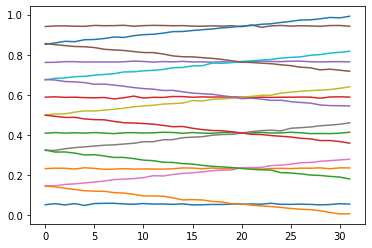

In [8]:
plot_lines = np.concatenate((x_train[1000:1010], x_train[11000:11010], x_train[21000:21010], x_train[31000:31010],x_train[41000:41010],x_train[51000:51010])) 
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Create model

In [9]:
# BATCH SIZE 64,128,256
# LEARNING RATE 0.001, 0.01, 0.005, 0.0005
# STDEV 0.1 0.5 0.05
# EPOCHS 1 5 10 20

# 3 * 4 * 3 * 4 = 144 modele

# batch_sizes = [64, 128, 256]
# learning_rates = [0.0005, 0.001, 0.005, 0.01]
# stdevs = [0.05, 0.1, 0.5]
# epochs = [1, 5, 10, 20]

batch_sizes = [64]
learning_rates = [0.01]
stdevs = [0.05]
epochs = [20]


original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
# batch_size = 64
latent_dim = 8
# epochs = 1

In [11]:
plt.ioff()
for bs in batch_sizes:
    for lr in learning_rates:
        for stdev in stdevs:
            for e in epochs:
                def sampling(args):
                    z_mean, z_log_var = args
                    batch = K.shape(z_mean)[0]
                    dim = K.int_shape(z_mean)[1]
                    # by default, random_normal has mean = 0 and std = 1.0
                    epsilon = K.random_normal(shape=(batch, dim), stddev=stdev)
                    return z_mean + K.exp(0.5 * z_log_var) * epsilon

                # ENCODER
                inputs = Input(shape=input_shape, name='encoder_input')
                x = Dense(intermediate_dim, activation='relu')(inputs)
                x = BatchNormalization()(x)
                z_mean = Dense(latent_dim, name='z_mean')(x)
                z_log_var = Dense(latent_dim, name='z_log_var')(x)
                z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
                encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
                # encoder.summary()

                # DECODER
                latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
                x = Dense(intermediate_dim, activation='relu')(latent_inputs)
                x = BatchNormalization()(x)
                outputs = Dense(original_dim, activation='sigmoid')(x)
                decoder = Model(latent_inputs, outputs, name='decoder')
                # decoder.summary()

                # VAE
                outputs = decoder(encoder(inputs)[2])
                vae = Model(inputs, outputs, name='vae_mlp')
                # vae.summary()

                # LOSS FUNCTION
                reconstruction_loss = MSE(inputs, outputs)
                reconstruction_loss *= original_dim
                kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
                kl_loss = K.sum(kl_loss, axis=-1)
                kl_loss *= -0.5
                vae_loss = K.mean(reconstruction_loss + kl_loss)

                vae.add_loss(vae_loss)
                optimizer = Adam(lr)
                vae.compile(optimizer=optimizer)

                # FIT MODEL
                hist = vae.fit(x_train,
                               verbose=0,
                               epochs=e,
                               batch_size=bs)
                
                # EVALUATE MODEL
                z_mean, _, _ = encoder.predict(x_train, batch_size=bs)
                db8_score = round(davies_bouldin_score(z_mean, y_train), 2)
                ch8_score = round(calinski_harabasz_score(z_mean, y_train), 2)
                loss = round(hist.history['loss'][0], 2)
                z_mean = PCA(n_components=2).fit_transform(z_mean)
                db2_score = round(davies_bouldin_score(z_mean, y_train), 2)
                ch2_score = round(calinski_harabasz_score(z_mean, y_train), 2)
                
                # SAVE MODEL AND RESULTS
                directory = "LINE_DETECTOR_VAE_MLP_RESULTS3/" + f"LOSS{loss}_8DBS{db8_score}_8CHS{ch8_score}_2DBS{db2_score}_2CHS{ch2_score}_LATENT{latent_dim}_STDEV{stdev}_BS{bs}_E{e}_LR{lr}"
                os.mkdir(directory)
                vae.save_weights(f'{directory}/vae/')
                encoder.save_weights(f'{directory}/encoder/')
                decoder.save_weights(f'{directory}/decoder/')
                
                plt.figure(figsize=(12,8))
                plt.scatter(z_mean[:, 0], z_mean[:, 1],  c=y_train)
                plt.savefig(f"{directory}/LATENT_SPACE.png")
                plt.close('all')

